In [268]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [340]:
def data_groups(data, headers):
    chasm_repeats = headers["params"]["detect"]["chasm_repeats"]
    antihole_repeats = headers["params"]["detect"]["antihole_repeats"]
    if "rf_repeats" in headers["params"]["detect"]:
        rf_repeats = headers["params"]["detect"]["rf_repeats"]
    else:
        rf_repeats = 0
    rf_frequencies = headers["params"]["rf"]["offsets_2"]
    total_detect_repeats = chasm_repeats + antihole_repeats + rf_repeats * len(rf_frequencies)
    experiment_repeats = headers["params"]["repeats"]

    chasm_avg = []
    antihole_avg = []
    rf_avg = []
    for kk in rf_frequencies:
        rf_avg.append([])
    for kk in range(len(data["transmissions_avg"])):
        remainder = kk % total_detect_repeats
        if remainder < chasm_repeats:
            chasm_avg.append(data["transmissions_avg"][kk])
        elif remainder < chasm_repeats + antihole_repeats:
            antihole_avg.append(data["transmissions_avg"][kk])
        else:
            index = (remainder - (chasm_repeats + antihole_repeats)) // rf_repeats
            rf_avg[index].append(data["transmissions_avg"][kk])
    chasm_avg = np.array(chasm_avg)
    antihole_avg = np.array(antihole_avg)
    rf_avg = np.array(rf_avg)
    chasm_avg = np.average(chasm_avg, axis=0)
    antihole_avg = np.average(antihole_avg, axis=0)
    rf_avg = np.average(rf_avg, axis=1)
    
    return (chasm_avg, antihole_avg, rf_avg)


In [341]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c
    

In [342]:
def rf_spectroscopy_field(data_list):
    positive_antihole_heights = []
    positive_antihole_height_errs = []
    negative_antihole_heights = []
    negative_antihole_height_errs = []
    positive_rf_heights = []
    positive_rf_height_errs = []
    negative_rf_heights = []
    negative_rf_height_errs = []

    chasm_avgs = []
    antihole_avgs = []
    rf_avgs = []
    for kk, number in enumerate(data_list):
        data, headers = get_experiment_data(number)
        detunings = headers["detunings"].to("MHz").magnitude
        offsets = headers["params"]["rf"]["offsets_2"].to("kHz").magnitude
        chasm_avg, antihole_avg, rf_avg = data_groups(data, headers)
        chasm_avgs.append(chasm_avg)
        antihole_avgs.append(antihole_avg)
        rf_avgs.append(rf_avg)

    chasm_avg = np.average(chasm_avgs, axis=0)
    antihole_avg = np.average(antihole_avgs, axis=0)
    rf_avg = np.average(rf_avgs, axis=0)

    # fit heights
    positive_mask = detunings > 0
    for ll, offset in enumerate(headers["params"]["rf"]["offsets_2"]):
        positive_rf_fit = get_gaussian_fit(detunings[positive_mask], rf_avg[ll][positive_mask]/chasm_avg[positive_mask], p0={"f_0": 2, "a": -0.1, "c": 1, "sigma": 0.3})
        positive_rf_heights.append(positive_rf_fit.results["a"])

    negative_mask = detunings < 0
    for ll in range(len(headers["params"]["rf"]["offsets_2"])):
        negative_rf_fit = get_gaussian_fit(detunings[negative_mask], rf_avg[ll][negative_mask]/chasm_avg[negative_mask], p0={"f_0": -2, "a": -0.1, "c": 1, "sigma": 0.3})
        negative_rf_heights.append(negative_rf_fit.results["a"])

    offsets = np.array(offsets)
    positive_rf_heights = np.array(positive_rf_heights)
    negative_rf_heights = np.array(negative_rf_heights)
    return offsets, positive_rf_heights, negative_rf_heights
    

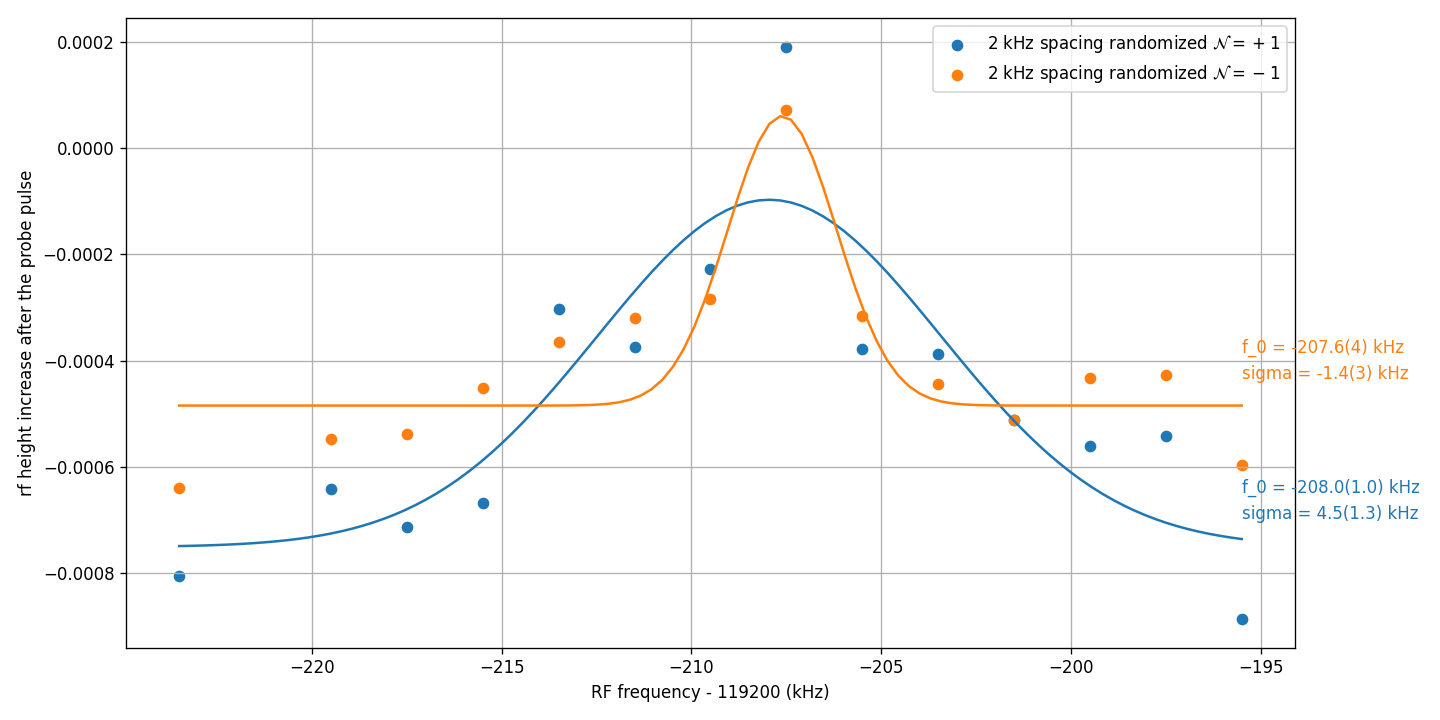

In [352]:
data = {
    #"2 kHz spacing": [16188, 16207],
    "3 kHz spacing": [16238, 16240],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, pos_ys, neg_ys = rf_spectroscopy_field(data_list)
    pos_ys = -np.diff(pos_ys)
    neg_ys = -np.diff(neg_ys)
    xs = xs[1:]
    ax.scatter(xs, pos_ys, label = label + " $\\mathcal{N}=+1$")
    ax.scatter(xs, neg_ys, label = label + " $\\mathcal{N}=-1$")
    mask = xs < -150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": -209})
    pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": -209})
    neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.0001, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.00005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.0001, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.00005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")

ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("rf height increase after the probe pulse")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [287]:
data, headers = get_experiment_data(16167)

In [288]:
(chasm_avg, antihole_avg, rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

800 8000


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

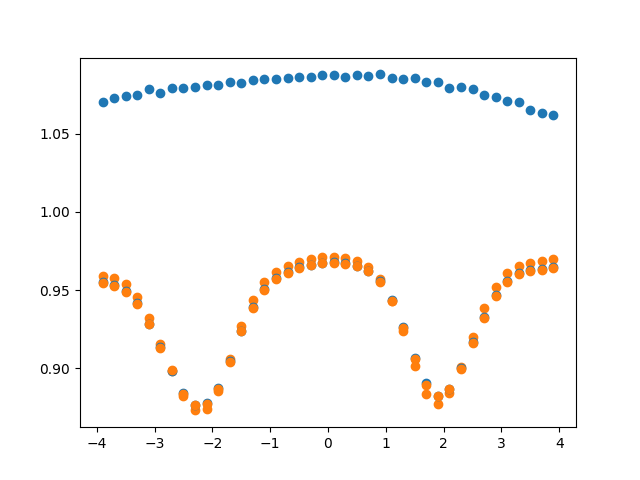

In [292]:
plt_monitor = False

antihole_normalized = antihole_avg/chasm_avg
rf_normalized = rf_avg/chasm_avg

fig, ax = plt.subplots()
ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")

ax.scatter(detunings_MHz, antihole_normalized, label="antihole", color="C1")
#antihole_fit = get_gaussian_fit(detunings_MHz, antihole_normalized)
xaxis = np.linspace(min(detunings_MHz), max(detunings_MHz), 1000)
#ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    for kk in rf_normalized:
        ax.scatter(detunings_MHz, kk, label="rf")
        rf_fit = get_gaussian_fit(detunings_MHz, kk)
        #ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
#plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.all_results_str())
print()
print(rf_fit.all_results_str())